## ng_viz_significant_structures
The purpose of this notebook is to make a Neuroglancer visualization of significant (p<0.01 & p<0.05) regions from three group comparisons. From Sam's email:
```
Basically, we want to visualize regions from rows shaded in green (p<0.01). Also maybe green and yellow together (p<0.05). See the fourth tab of the attached Excel file, which is Compare learning-reversal-VI. Column E is of the most interest. Columns C and A would be good to look at too.

I was thinking display positive z-values in red, negative z-values in blue. (Will, Jess, note that I inverted the sign in column F).
```
The A, C and E columns refer to group comparisons:
- Column A: Acquisition over habituation	
- Column C: Reversal over nonreversal	
- Column E: Reversal over Lobule VI reversal	

Below I make a pandas dataframe that contains the region names and p-value and z-score information necessary to make the Neuroglancer visualizations.

In total there will be 6 figures, 2 for each group comparison because we want p<0.01 and p<0.05 separately.

The complicated part of this is the fact that not all of the brain regions in the dataframe are part of the PMAs default display hierarchy. For example, `Hippocampal region` is in the dataframe list but if you search for it in Neuroglancer nothing shows up. See this file: https://nbviewer.jupyter.org/github/PrincetonUniversity/lightsheet_helper_scripts/blob/master/projects/combine_cfos_batches/data/PMA_regions.html for a list of all regions in PMA and the subset (in bold) that are displayed at the default hierarchy level. So I will need to traverse the hierarchy for each brain region in my filter and color the descendants as well. 

In [1]:
import neuroglancer as ng
from neuroglancer import webdriver as webd

import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import edt
import graphviz

%matplotlib inline

## Data loading -- common for all plots

In [3]:
main_file = '../data/Compare_learning-reversal-VI.csv'
pma_segment_props_file = '../data/pma_segment_properties_info_orighierarchy'
pma_ontology_json_file = '../data/PMA_ontology.json'

In [4]:
# Read in the dataframe containing the z-score and p-values for each of the 3 group comparisons
df = pd.read_csv(main_file)
df

,regionA,z_valueA,pthreshA,regionB,z_valueB,pthreshB,regionC,z_valueC,pthreshC
0,Anterior amygdalar area,0.280372,-1.00,Anterior amygdalar area,-2.048305,-1.00,Anterior amygdalar area,-0.951032,-1.00
1,Anterior cingulate area,-0.489121,-1.00,Anterior cingulate area,-2.925135,0.05,Anterior cingulate area,-3.310000,0.01
2,Anterior tegmental nucleus,0.700663,-1.00,Anterior tegmental nucleus,4.476327,0.01,Anterior tegmental nucleus,1.279963,-1.00
3,Anterodorsal nucleus,1.654116,-1.00,Anterodorsal nucleus,4.022466,0.01,Anterodorsal nucleus,5.873849,0.01
4,Anterodorsal preoptic nucleus,5.618569,0.01,Anterodorsal preoptic nucleus,1.268048,-1.00,Anterodorsal preoptic nucleus,3.407765,0.01
...,...,...,...,...,...,...,...,...,...
105,Ventral tegmental nucleus,-0.257403,-1.00,Ventral tegmental nucleus,2.491521,0.05,Ventral tegmental nucleus,2.778352,0.05
106,Ventrolateral preoptic nucleus,1.441913,-1.00,Ventrolateral preoptic nucleus,-0.540690,-1.00,Ventrolateral preoptic nucleus,-1.444742,-1.00
107,Visceral area,0.984438,-1.00,Visceral area,-3.166181,0.01,Visceral area,-0.831838,-1.00
108,Visual areas,-2.599464,0.05,Visual areas,-1.840618,-1.00,Visual areas,1.240327,-1.00


In [5]:
# Make a dictionary mapping region name to region ID
with open(pma_segment_props_file,'r') as infile:
    segment_properties = json.load(infile)

ids = segment_properties['inline']['ids']
segment_names = segment_properties['inline']['properties'][0]['values']
segment_name_dict = {segment_names[ii].split(':')[-1].strip():int(ids[ii]) for ii in range(len(ids))} # map name to ID

# Make sure all region names from our dataframe are in this dictionary
for region_name in df['regionA']:
    if region_name not in segment_name_dict:
        print(region_name)

In [6]:
# All regions in the dataframe are in our dictionary, which means we know their ID and can therefore display
# them in Neuroglancer

## Make function to get all descendents (aka progeny) of a given brain region

In [7]:
with open(pma_ontology_json_file,'r') as infile:
    pma_ontology_dict = json.load(infile)

In [8]:
def get_progeny(dic,parent_structure,progeny_list):
    """ 
    ---PURPOSE---
    Get a list of all progeny of a structure name.
    This is a recursive function which is why progeny_list is an
    argument and is not returned.
    ---INPUT---
    dic                  A dictionary representing the JSON file 
                         which contains the ontology of interest
    parent_structure     The structure
    progeny_list         The list to which this function will 
                         append the progeny structures. 
    """
    name = dic.get('name')
    children = dic.get('children')
    if name == parent_structure:
        for child in children: # child is a dict
            child_name = child.get('name')
            progeny_list.append(child_name)
            get_progeny(child,parent_structure=child_name,progeny_list=progeny_list)
        return
    
    for child in children:
        child_name = child.get('name')
        get_progeny(child,parent_structure=parent_structure,progeny_list=progeny_list)
    return

In [9]:
# Test it:
soi = 'Hippocampal region'
progeny_list=[]
get_progeny(pma_ontology_dict,parent_structure=soi,progeny_list=progeny_list)
progeny_list

['Induseum griseum',
 "Ammon's horn",
 'Field CA1',
 'Field CA1, stratum lacunosum-moleculare',
 'Field CA1, stratum oriens',
 'Field CA1, pyramidal layer',
 'Field CA1, stratum radiatum',
 'Field CA2',
 'Field CA2, stratum lacunosum-moleculare',
 'Field CA2, stratum oriens',
 'Field CA2, pyramidal layer',
 'Field CA2, stratum radiatum',
 'Field CA3',
 'Field CA3, stratum lacunosum-moleculare',
 'Field CA3, stratum lucidum',
 'Field CA3, stratum oriens',
 'Field CA3, pyramidal layer',
 'Field CA3, stratum radiatum',
 'Dentate gyrus',
 'Dentate gyrus, granule cell layer',
 'Dentate gyrus crest',
 'Dentate gyrus crest, molecular layer',
 'Dentate gyrus crest, polymorph layer',
 'Dentate gyrus crest, granule cell layer',
 'Dentate gyrus lateral blade',
 'Dentate gyrus lateral blade, molecular layer',
 'Dentate gyrus lateral blade, polymorph layer',
 'Dentate gyrus lateral blade, granule cell layer',
 'Dentate gyrus medial blade',
 'Dentate gyrus medial blade, molecular layer',
 'Dentate g

## Start a Neuroglancer session 

In [10]:
ng.set_static_content_source(url='https://neuroglancer-braincogs.appspot.com')

In [113]:
viewer = ng.Viewer()
with viewer.txn() as s:
#     s.layers['PMA_boundaries'] = ng.SegmentationLayer(source='precomputed://http://localhost:1338'
#     )
    s.layers['PMA_background'] = ng.SegmentationLayer(source='precomputed://gs://wanglab-pma/princetonmouse'
    )
    s.layers['PMA'] = ng.SegmentationLayer(source='precomputed://gs://wanglab-pma/princetonmouse'
    )
    
print(viewer)

http://127.0.0.1:40601/v/abc0301c58bc679eb9f51d7843f62f829b020b68/


## Define function to make the plot for a given group comparison (A,C,E) and p-value threshold

In [114]:
def setup_neuroglancer_screenshot(column='C',pthresh=0.01):
    """ 
    ---PURPOSE---
    Set up a Neuroglancer session using an existing viewer object
    for a screenshot given
    a column in tab 4 of the group comparison spreadsheet
    ---INPUT---
    column        'A','C' or 'E'. See top of notebook for what these mean
    pthresh       p-value threshold. 0.01 or 0.05
    """
    if column == 'A':
        pthresh_col = df.pthreshA
    elif column == 'B':
        pthresh_col = df.pthreshB
    elif column == 'C':
        pthresh_col = df.pthreshC
    if pthresh == 0.05:
        pval_mask = np.logical_or(pthresh_col==0.05,pthresh_col==0.01)
    else:
        pval_mask = pthresh_col==pthresh
    df_masked = df.loc[pval_mask]
    regions_thiscol_pthresh = df_masked['region{}'.format(column)].values
    # positive z-scores in red, negative in blue
    zpos_mask = df_masked['z_value{}'.format(column)] > 0 
    zneg_mask = df_masked['z_value{}'.format(column)] < 0
    df_masked_zpos = df_masked[zpos_mask]
    df_masked_zneg = df_masked[zneg_mask]

    regions_zpos = df_masked_zpos['region{}'.format(column)].values
    regions_zneg = df_masked_zneg['region{}'.format(column)].values
    # Find the descendants in the hierarchy for each subset so we can color them as well
    all_regions_zpos = []
    for soi in regions_zpos:
        all_regions_zpos.append(soi)
        progeny_list=[]
        get_progeny(pma_ontology_dict,parent_structure=soi,progeny_list=progeny_list)
        all_regions_zpos.extend(progeny_list)

    all_regions_zneg = []
    for soi in regions_zneg:
        all_regions_zneg.append(soi)
        progeny_list=[]
        get_progeny(pma_ontology_dict,parent_structure=soi,progeny_list=progeny_list)
        all_regions_zneg.extend(progeny_list)
    all_regions = all_regions_zpos + all_regions_zneg
    ids_zpos = [segment_name_dict[name] for name in all_regions_zpos]
    ids_zneg = [segment_name_dict[name] for name in all_regions_zneg]
    ids_all = [segment_name_dict[name] for name in all_regions]
    with viewer.txn() as s:
        # Viewer position and zoom
        s.showAxisLines = False
        s.showSlices = False
        s.position = [166.3549346923828, 269.5, 287.5]
        s.crossSectionOrientation = [0, 0, -0.7071067690849304, 0.7071067690849304]
        s.crossSectionScale = 1.6878530899468827
        s.projectionOrientation = [-0.25872182846069336, 0.013326199725270271, -0.7424709796905518, 0.6177558302879333]
        s.projectionScale = 602.7314889506351
        s.projectionBackgroundColor =  "#0a0a0a"
        s.crossSectionBackgroundColor =  "#0a0a0a"
        seglayer = s.layers['PMA']
        seglayer.selectedAlpha = 0.78
        seglayer.objectAlpha = 0.17
        seglayer.segments = ids_all
        zpos_color_dict = {ID:'#03fc45' for ID in ids_zpos} 
        zneg_color_dict = {ID:'#fcec03' for ID in ids_zneg}
        color_dict = {**zpos_color_dict,**zneg_color_dict}
        seglayer.segmentColors = color_dict
        bglayer = s.layers['PMA_background']
        bglayer.saturation=1.0
        bglayer_segments = ids + [43808,1216,41536,54272,43776,50080,50096]
        bglayer.segments = bglayer_segments
        bglayer_color_dict = {x:'#757575' for x in bglayer_segments}
        bglayer.segmentColors = bglayer_color_dict
        bglayer.objectAlpha=0.07
        bglayer.meshSilhouetteRendering = 0.0

In [115]:
setup_neuroglancer_screenshot(column='C',pthresh=0.01)


In [ ]:
# Then take the screenshot with GIMP or whatever program you want to use. You can use Neuroglancer's webdriver
# to do that too.

## Add labels with Python

In [100]:
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle
from matplotlib.text import Text
from matplotlib.lines import Line2D
from PIL import Image

In [16]:
filename='../figs/Acquisition_over_habituation_p001_v4.png'

In [17]:
image = mpimg.imread(filename)

In [18]:
pil_im = Image.open(filename)

In [19]:
pil_im.size

(1177, 615)

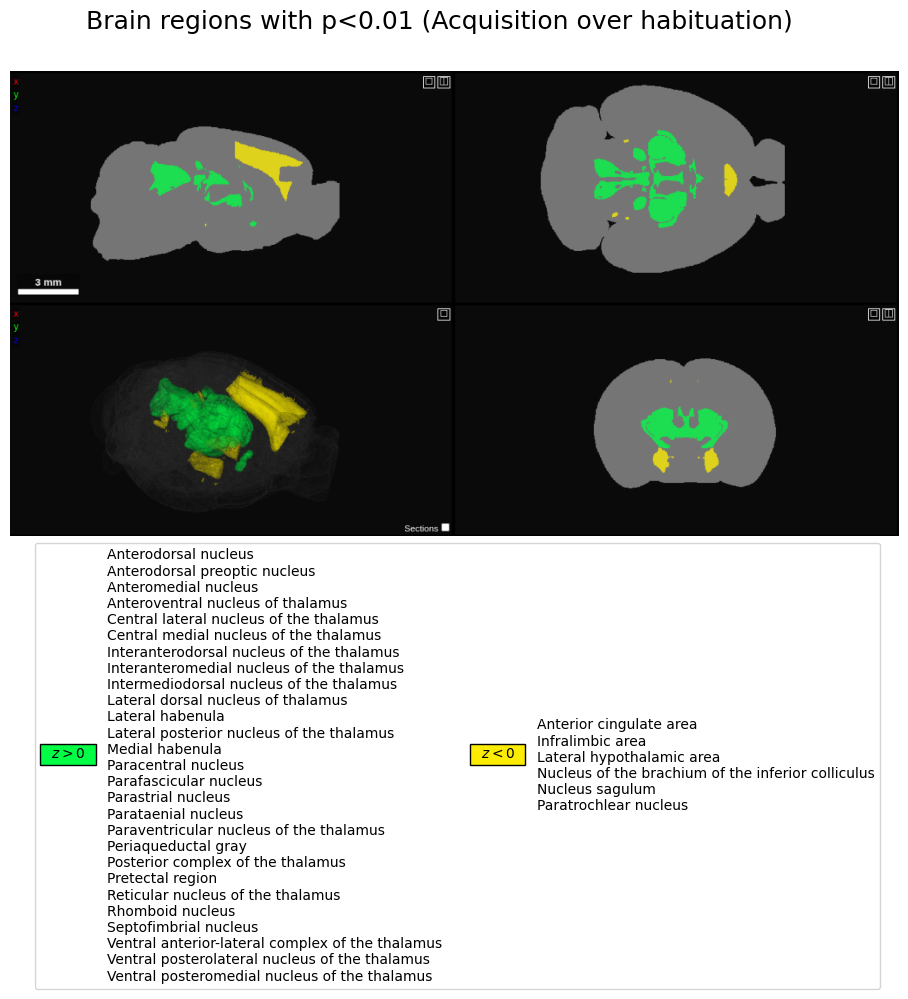

In [70]:
my_dpi=100
fig = plt.figure(figsize=(float(pil_im.size[0]) / my_dpi,float(pil_im.size[1]) / my_dpi), dpi=my_dpi)
ax=fig.add_subplot(111)
ax.imshow(image)
handles = [
    Rectangle((0,0),1,1, color = '#03fc45',label='test'),
    Rectangle((0,0),1,1, color = '#fcec03'),
    
]
labels = ['\n'.join(x for x in regionsC_p001_zpos),'\n'.join(x for x in regionsC_p001_zneg)]

class Handler(object):
    def __init__(self, color,text):
        self.color=color
        self.text = text
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        width, height = handlebox.width, handlebox.height
        rect_patch = plt.Rectangle([x0, y0], width, height, facecolor=self.color,
                                   edgecolor='k', transform=handlebox.get_transform())
        text_patch = Text(x0+width/2.,y0+height/2., self.text, fontsize=fontsize,
                  ha="center", va="center")
        
        handlebox.add_artist(rect_patch)
        handlebox.add_artist(text_patch)
        
        return rect_patch
colors = ['#03fc45','#fcec03']
texts = [r'$z > 0$',r'$z < 0$']
hmap = dict(zip(handles, [Handler(colors[ii],texts[ii]) for ii in range(2)] ))

ax.legend(handles=handles,labels=labels,bbox_to_anchor=(0.02, 0.), loc='upper left',ncol=2,
         handlelength=4,handleheight=2,handler_map=hmap)
ax.axis('off')
fig.suptitle("Brain regions with p<0.01 (Acquisition over habituation)",fontsize=18)
plt.savefig('../figs/Acquisition_over_habituation_p001_v5.png',bbox_inches = "tight")